In [1]:
from math import sqrt
import matplotlib.pyplot as plt

import torch
import Steerable.nn as snn

# Gaussian Noise Dataset

In [2]:
class GaussianDataset(torch.utils.data.Dataset):
    def __init__(self, size, mean=0.0, std=1.0, length=1000):
        self.mean = mean
        self.std = std
        self.size = size
        self.length = length

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        if idx >= self.length:
            raise ValueError(f'Index{idx} out of range for dataset of length {self.length}')
        image = torch.randn(self.size) * self.std + self.mean
        label = 0
        return image, label

# Function to Check Equivariance

In [6]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
def check_equivariance(model, dataset, transfomation=None):
    def diff_output(inputs1, inputs2):
        with torch.no_grad():
            outputs1 = model(inputs1.unsqueeze(0).to(device))[0]
            outputs2 = model(inputs2.unsqueeze(0).to(device))[0]
            diff_norm = torch.linalg.vector_norm(outputs1-outputs2)
            norm1 = torch.linalg.vector_norm(outputs1)
            norm2 = torch.linalg.vector_norm(outputs1)
            return (diff_norm/sqrt(norm1*norm2)).item() * 100
        
    n_sim = 50
    degrees = torch.arange(0, 361, 90)
    values = torch.zeros(n_sim, len(degrees))
    
    for sim in range(n_sim):
        inputs = dataset[torch.randint(0, len(dataset), (1,)).item()][0]
        with torch.no_grad():
            for parameters in model.parameters():
                parameters.copy_(torch.randn_like(parameters))
            for i, degree in enumerate(degrees):
                inputs_rot = transfomation(inputs, degree) if transfomation else inputs
                values[sim, i] = diff_output(inputs, inputs_rot)

        print(f'Simulation : {sim+1} / {n_sim}', end='\r')

    diff_mean = values.mean(dim=0)
    diff_std = values.std(dim=0)

    plt.plot(degrees, diff_mean)
    plt.fill_between(degrees, diff_mean-1.95*diff_std/sqrt(n_sim),  diff_mean+1.95*diff_std/sqrt(n_sim), color='blue', alpha=0.2)
    plt.xticks([45*i for i in range(degrees.max().item()//45 + 1)])
    for intercept in [90*i+45 for i in range(round(degrees.max().item()/90))]:
        plt.axvline(intercept, linestyle='dashed', color='red')
    plt.xlabel('Degree', size=15)
    plt.ylabel('Error %',size=15)
    plt.show()

# Two Dimension

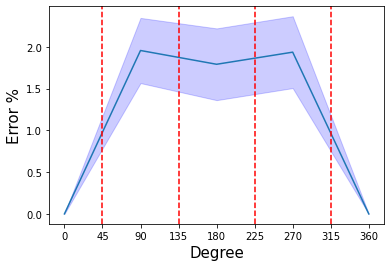

In [7]:
# Model
class Model(torch.nn.Module):
    def __init__(self) -> None:
        super().__init__()
        freq_cutoff = 8
        n_angle = 24
        interpolation_type = -1

        self.network = torch.nn.Sequential(
            snn.SE2ConvType1(1, 2, 5, freq_cutoff, n_angle=n_angle, padding='same', interpolation_type=interpolation_type),
            snn.SE2CGNonLinearity(2, 8, n_angle),
            snn.SE2BatchNorm(),
            snn.SE2ConvType2(2, 2, 5, freq_cutoff, n_angle=n_angle, padding='same', interpolation_type=interpolation_type),
            snn.SE2BatchNorm(),
   
            snn.SE2AvgPool(4),
            snn.SE2ConvType2(2, 2, 7,freq_cutoff, n_angle=n_angle, interpolation_type=interpolation_type),

            snn.SE2NormFlatten()
        )

    def forward(self,x):
        return self.network(x.type(torch.cfloat))

# Check Equivariance
model = Model().to(device)
dataset = GaussianDataset(size =(1,28,28))
check_equivariance(model, dataset, lambda x, degree:snn.rotate_image(x, degree))

# Three Dimension

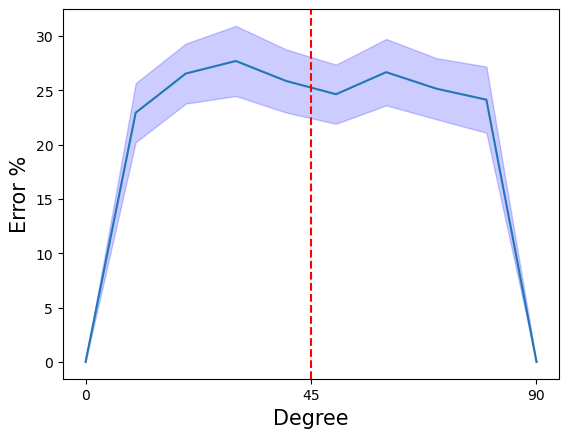

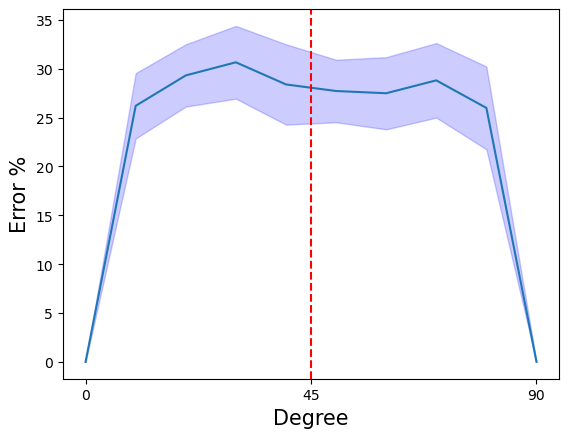

In [5]:
# Model
class Model(torch.nn.Module):
    def __init__(self) -> None:
        super().__init__()
        n_angle = 256
        
        self.network = torch.nn.Sequential(
            snn.SE3Conv(1, [2,3], 3, n_angle=n_angle, padding='same'),
            snn.SE3NormNonLinearity([2,3]),
            snn.SE3Conv([2,3], [4,5], 3, n_angle=n_angle, padding='same'),
            snn.SE3BatchNorm(),
            
            snn.SE3AvgPool(4),
            
            snn.SE3Conv([4, 5], [4, 5], 8, n_angle=n_angle),
            snn.SE3NormFlatten()
        )
    def forward(self,x):
        return self.network(x.type(torch.cfloat))
    
# Check Equivariance
model = Model().to(device)
dataset = GaussianDataset(size =(1,32,32,32))
check_equivariance(model, dataset, lambda x, degree:snn.rotate_image(x, (degree,0,0))) # rotation about z-axis
check_equivariance(model, dataset, lambda x, degree:snn.rotate_image(x, (0,degree,0))) # rotation about y-axis